# **Análisis de Ventas - Coral Tech**

Este proyecto analiza los datos de ventas de la empresa Coral Tech a partir de archivos CSV.
Se utilizan herramientas de Python como Pandas y Matplotlib para procesar la información y generar gráficos que muestran:

* El rendimiento general de ventas
* Los rubros más rentables
* Los clientes más importantes
* La evolución mensual de las ventas
* Los productos más vendidos

El objetivo es obtener una visión clara y profesional de los resultados comerciales y apoyar la toma de decisiones.

**Carga de datos**


Primero se importan las librerías necesarias y se cargan los archivos CSV desde la carpeta “csv de ventas”, que contiene toda la información del sistema (clientes, facturas, productos, rubros y detalles de facturas).

Tienen que existir los cvs en la carpeta "csv de ventas" para poder re

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

base_path = "csv de ventas/"
archivos = ["cliente.csv", "factura.csv", "detalle_factura.csv", "producto.csv", "rubro.csv"]
faltantes = [f for f in archivos if not os.path.exists(os.path.join(base_path, f))]
if faltantes:
    mensaje = "❌ ERROR: No se encontraron los siguientes archivos requeridos:\n"
    for f in faltantes:
        mensaje += f"   - {f}\n"
    mensaje += "\n Revisá la carpeta 'csv de ventas' antes de ejecutar el análisis."
    raise FileNotFoundError(mensaje)
else:
    # Cargar los CSV si existen
    clientes = pd.read_csv(base_path + "cliente.csv")
    facturas = pd.read_csv(base_path + "factura.csv")
    detalle = pd.read_csv(base_path + "detalle_factura.csv")
    productos = pd.read_csv(base_path + "producto.csv")
    rubros = pd.read_csv(base_path + "rubro.csv")

**Preparación de los datos**


Se combinan las tablas mediante sus claves para crear un único DataFrame que contenga toda la información consolidada.
Además, se calcula el subtotal de cada producto y se formatea la fecha correctamente.

In [4]:
df = detalle.merge(productos, on="id_producto", how="left")
df = df.merge(rubros, on="id_rubro", how="left")
df = df.merge(facturas, on="id_factura", how="left")
df = df.merge(clientes, on="id_cliente", how="left")

df["subtotal"] = df["cantidad"] * df["precio_unitario"]
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")

**Cálculo de métricas generales**

Se obtienen los valores globales del sistema:

* Total de ventas realizadas
* Cantidad de facturas
* Número de clientes únicos
* Total de productos vendidos

Además, se calculan las unidades vendidas por producto.

In [5]:
total_ventas = df["subtotal"].sum()
total_facturas = df["id_factura"].nunique()
total_clientes = df["id_cliente"].nunique()
total_productos = df["id_producto"].nunique()

ventas_cantidad = df.groupby("descripcion")["cantidad"].sum().sort_values(ascending=False)

**Métricas principales**

Se visualizan los indicadores más importantes de la empresa, incluyendo el total de ventas, facturas emitidas, clientes activos y el producto más vendido.

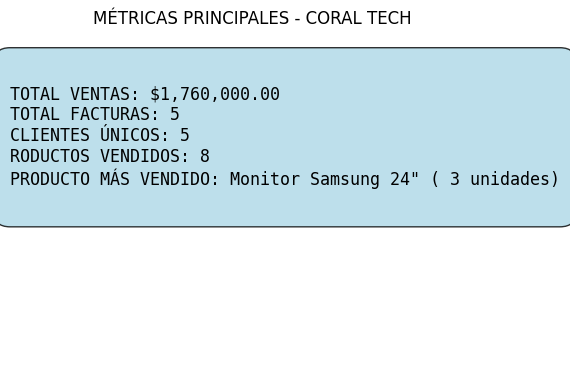

In [6]:
plt.figure(figsize=(6, 4))
producto_mas_vendido = ventas_cantidad.index[0]
cantidad_mas_vendido = ventas_cantidad.values[0]

metricas_texto = f"""
TOTAL VENTAS: ${total_ventas:,.2f}
TOTAL FACTURAS: {total_facturas}
CLIENTES ÚNICOS: {total_clientes}
RODUCTOS VENDIDOS: {total_productos}
PRODUCTO MÁS VENDIDO: {producto_mas_vendido[:25]} ( {cantidad_mas_vendido} unidades)
"""

plt.axis('off')
plt.text(0, 0.5, metricas_texto, fontsize=12, fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=1", facecolor="lightblue", alpha=0.8))
plt.title("MÉTRICAS PRINCIPALES - CORAL TECH")
plt.tight_layout()
plt.show()


**Ventas por rubro**

Muestra los rubros con mayor monto total de ventas, permitiendo identificar qué áreas del negocio son más rentables.

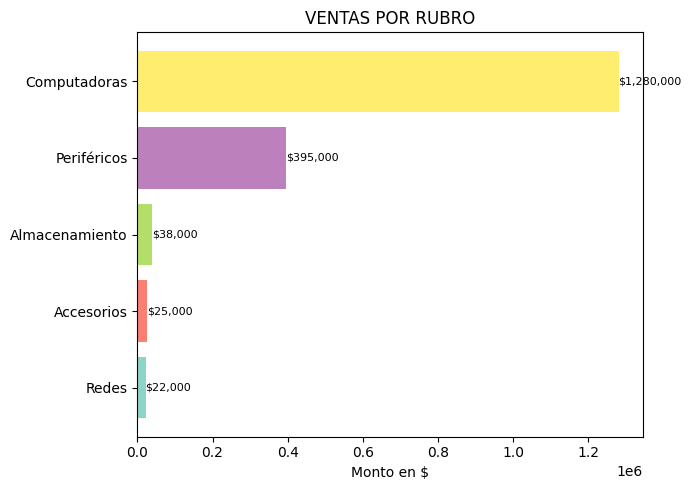

In [7]:
ventas_rubro = df.groupby("nombre_rubro")["subtotal"].sum().sort_values(ascending=True)

plt.figure(figsize=(7, 5))
colors_rubro = plt.cm.Set3(np.linspace(0, 1, len(ventas_rubro)))
bars = plt.barh(ventas_rubro.index, ventas_rubro.values, color=colors_rubro)

plt.title("VENTAS POR RUBRO")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'${bar.get_width():,.0f}', va='center', fontsize=8)
plt.xlabel("Monto en $")
plt.tight_layout()
plt.show()


**Top clientes**

Se listan los clientes más importantes de la empresa según el monto total de compras realizadas.

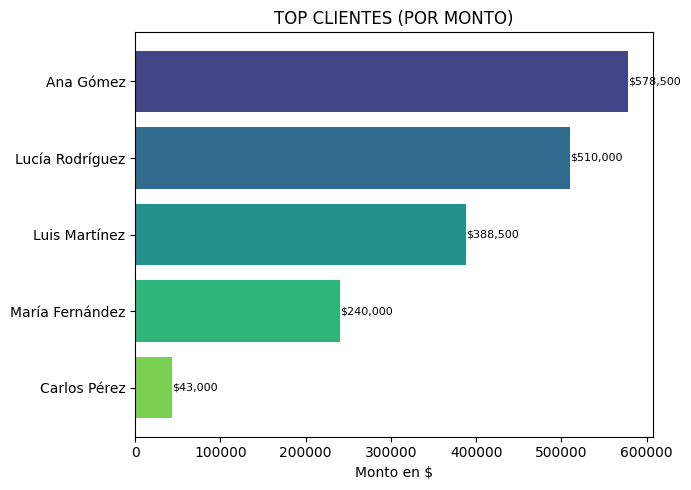

In [8]:
top_clientes = df.groupby("nombre")["subtotal"].sum().sort_values(ascending=False).head(8)

plt.figure(figsize=(7, 5))
colors_clientes = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_clientes)))
bars = plt.barh(top_clientes.index, top_clientes.values, color=colors_clientes)

plt.title("TOP CLIENTES (POR MONTO)")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'${bar.get_width():,.0f}', va='center', fontsize=8)
plt.xlabel("Monto en $")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Promedio de ventas por día de la semana**

Muestra qué días registran mayores y menores ventas, revelando los patrones semanales de rendimiento comercial.

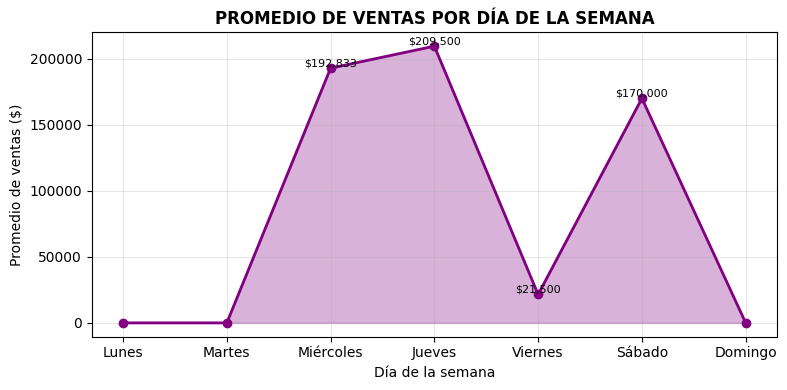

In [18]:
df["dia_semana"] = df["fecha"].dt.day_name()

ventas_semana = df.groupby("dia_semana")["subtotal"].mean()

orden_dias = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ventas_semana = ventas_semana.reindex(orden_dias, fill_value=0)  # ← agrega los faltantes con 0

dias_es = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

plt.figure(figsize=(8, 4))
plt.fill_between(dias_es, ventas_semana.values, alpha=0.3, color='purple')
plt.plot(dias_es, ventas_semana.values, marker='o', color='purple', linewidth=2)
plt.title("PROMEDIO DE VENTAS POR DÍA DE LA SEMANA", fontsize=12, fontweight='bold')
plt.xlabel("Día de la semana")
plt.ylabel("Promedio de ventas ($)")
plt.grid(True, alpha=0.3)

# Mostrar valores sobre cada punto
for i, valor in enumerate(ventas_semana.values):
    if valor > 0:
        plt.text(i, valor, f'${valor:,.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


**Evolución mensual de ventas**

Analiza cómo varían las ventas mes a mes durante el año 2025, mostrando los picos y caídas en el rendimiento comercial.

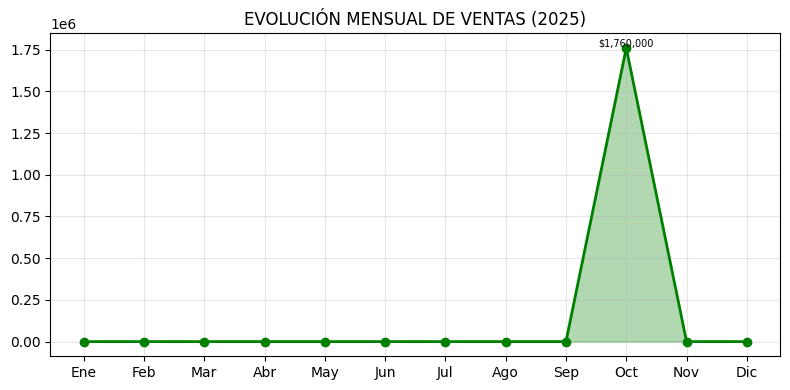

In [9]:
df_2025 = df[df["fecha"].dt.year == 2025]
ventas_2025_mes = df_2025.groupby(df_2025["fecha"].dt.month)["subtotal"].sum().reindex(range(1,13), fill_value=0)
meses = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

plt.figure(figsize=(8, 4))
plt.fill_between(range(1,13), ventas_2025_mes.values, alpha=0.3, color='green')
plt.plot(range(1,13), ventas_2025_mes.values, marker='o', color='green', linewidth=2)
plt.xticks(range(1,13), meses)
plt.grid(True, alpha=0.3)
plt.title("EVOLUCIÓN MENSUAL DE VENTAS (2025)")
for i, valor in enumerate(ventas_2025_mes.values):
    if valor > 0:
        plt.text(i+1, valor, f'${valor:,.0f}', ha='center', va='bottom', fontsize=7)
plt.tight_layout()
plt.show()


**Evolución de Ventas a lo Largo de los Años**

El análisis interanual muestra una tendencia general de crecimiento, con aumentos sostenidos en las ventas y mejoras en el rendimiento comercial.
Si bien algunos años registraron fluctuaciones puntuales por factores externos, la evolución global refleja una consolidación progresiva del negocio y una mayor estabilidad en el mercado.

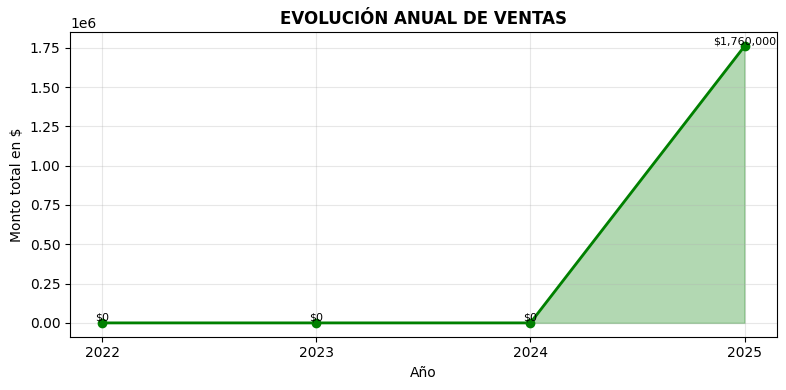

In [ ]:
anios = range(2022, 2026)
ventas_anuales = df.groupby(df["fecha"].dt.year)["subtotal"].sum().reindex(anios, fill_value=0)

plt.figure(figsize=(8, 4))
plt.fill_between(ventas_anuales.index, ventas_anuales.values, alpha=0.3, color='green')
plt.plot(ventas_anuales.index, ventas_anuales.values, marker='o', color='green', linewidth=2)
plt.xticks(ventas_anuales.index, [str(año) for año in ventas_anuales.index])
plt.grid(True, alpha=0.3)
plt.title("EVOLUCIÓN ANUAL DE VENTAS", fontsize=12, fontweight='bold')
plt.xlabel("Año")
plt.ylabel("Monto total en $")

for i, valor in enumerate(ventas_anuales.values):
    plt.text(ventas_anuales.index[i], valor, f'${valor:,.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


**Productos más vendidos**

Muestra los 10 productos con mayor cantidad de unidades vendidas, permitiendo identificar los artículos más populares.

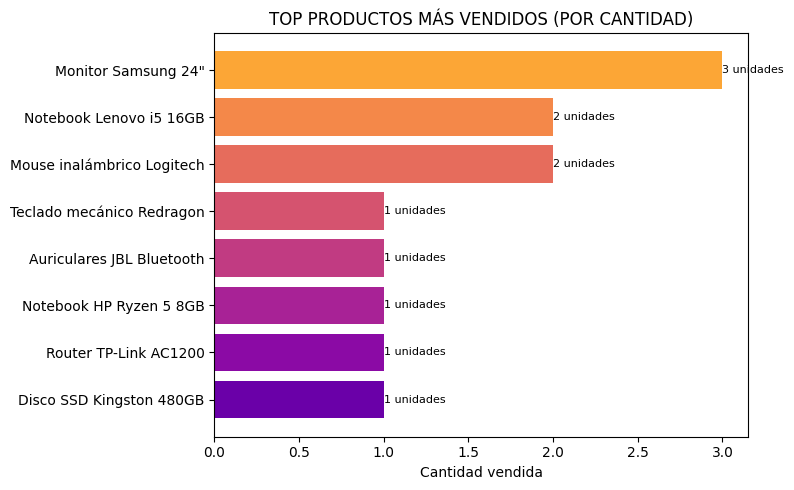

In [11]:
top_productos_cantidad = ventas_cantidad.head(10).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
colors_productos = plt.cm.plasma(np.linspace(0.2, 0.8, len(top_productos_cantidad)))
bars = plt.barh(top_productos_cantidad.index, top_productos_cantidad.values, color=colors_productos)

plt.title("TOP PRODUCTOS MÁS VENDIDOS (POR CANTIDAD)")
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.0f} unidades', va='center', fontsize=8)
plt.xlabel("Cantidad vendida")
plt.tight_layout()
plt.show()

**Resumen ejecutivo**

Finalmente, se genera un resumen textual con las principales métricas, los clientes destacados y la distribución de ventas por rubro.

In [12]:
print(f"\n TOP CLIENTES (POR MONTO):")
top_clientes_resumen = df.groupby("nombre")["subtotal"].sum().sort_values(ascending=False).head(5)
for i, (cliente, monto) in enumerate(top_clientes_resumen.items(), 1):
    print(f"   {i}. {cliente}: ${monto:,.2f}")

print(f"\n PRODUCTOS MÁS VENDIDOS (POR CANTIDAD):")
for i, (producto, cantidad) in enumerate(ventas_cantidad.head(5).items(), 1):
    monto_producto = df[df["descripcion"] == producto]["subtotal"].sum()
    print(f"   {i}. {producto}")
    print(f"      Cantidad: {cantidad} unidades | Monto: ${monto_producto:,.2f}")

print(f"\n VENTAS POR RUBRO:")
ventas_rubro = df.groupby("nombre_rubro")["subtotal"].sum().sort_values(ascending=False)
for rubro, venta in ventas_rubro.items():
    porcentaje = (venta / total_ventas) * 100
    print(f"   • {rubro}: ${venta:,.2f} ({porcentaje:.1f}%)")



 TOP CLIENTES (POR MONTO):
   1. Ana Gómez: $578,500.00
   2. Lucía Rodríguez: $510,000.00
   3. Luis Martínez: $388,500.00
   4. María Fernández: $240,000.00
   5. Carlos Pérez: $43,000.00

 PRODUCTOS MÁS VENDIDOS (POR CANTIDAD):
   1. Monitor Samsung 24"
      Cantidad: 3 unidades | Monto: $360,000.00
   2. Mouse inalámbrico Logitech
      Cantidad: 2 unidades | Monto: $17,000.00
   3. Notebook Lenovo i5 16GB
      Cantidad: 2 unidades | Monto: $900,000.00
   4. Disco SSD Kingston 480GB
      Cantidad: 1 unidades | Monto: $38,000.00
   5. Auriculares JBL Bluetooth
      Cantidad: 1 unidades | Monto: $25,000.00

 VENTAS POR RUBRO:
   • Computadoras: $1,280,000.00 (72.7%)
   • Periféricos: $395,000.00 (22.4%)
   • Almacenamiento: $38,000.00 (2.2%)
   • Accesorios: $25,000.00 (1.4%)
   • Redes: $22,000.00 (1.2%)
